In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd

In [2]:
def plot_channels(data, time, channels, limit = None):
    figure, axes = plt.subplots(nrows = len(channels), figsize = (20, 0.75 * len(channels)))
    plt.subplots_adjust(
        left = 0.1,
        bottom = 0.1,
        right = 0.9,
        top = 0.9,
        wspace = 0,
        hspace = 0
    )

    x = time

    for i, channel in enumerate(channels):
        y = data[:, i]
        axes[i].plot(x, y, linewidth = 0.5, color = 'black')

        if limit is not None:
            axes[i].set_ylim(-limit, limit)

        axes[i].set_xlim(0, 10)
        axes[i].get_xaxis().set_ticks([])
        axes[i].get_yaxis().set_ticks([])
        axes[i].set_ylabel(channel, rotation = 0, labelpad = 60, loc = 'center')

        if i != 0:
            axes[i].spines['top'].set_visible(False)

        if i != len(channels) - 1:
            axes[i].spines['bottom'].set_visible(False)

    plt.show()

In [17]:
with open('output/spontaneous-movement/W1/C1/emg/raw.pkl', 'rb') as file:
    raw = pickle.load(file)

channels = raw.ch_names
sfreq = raw.info['sfreq']

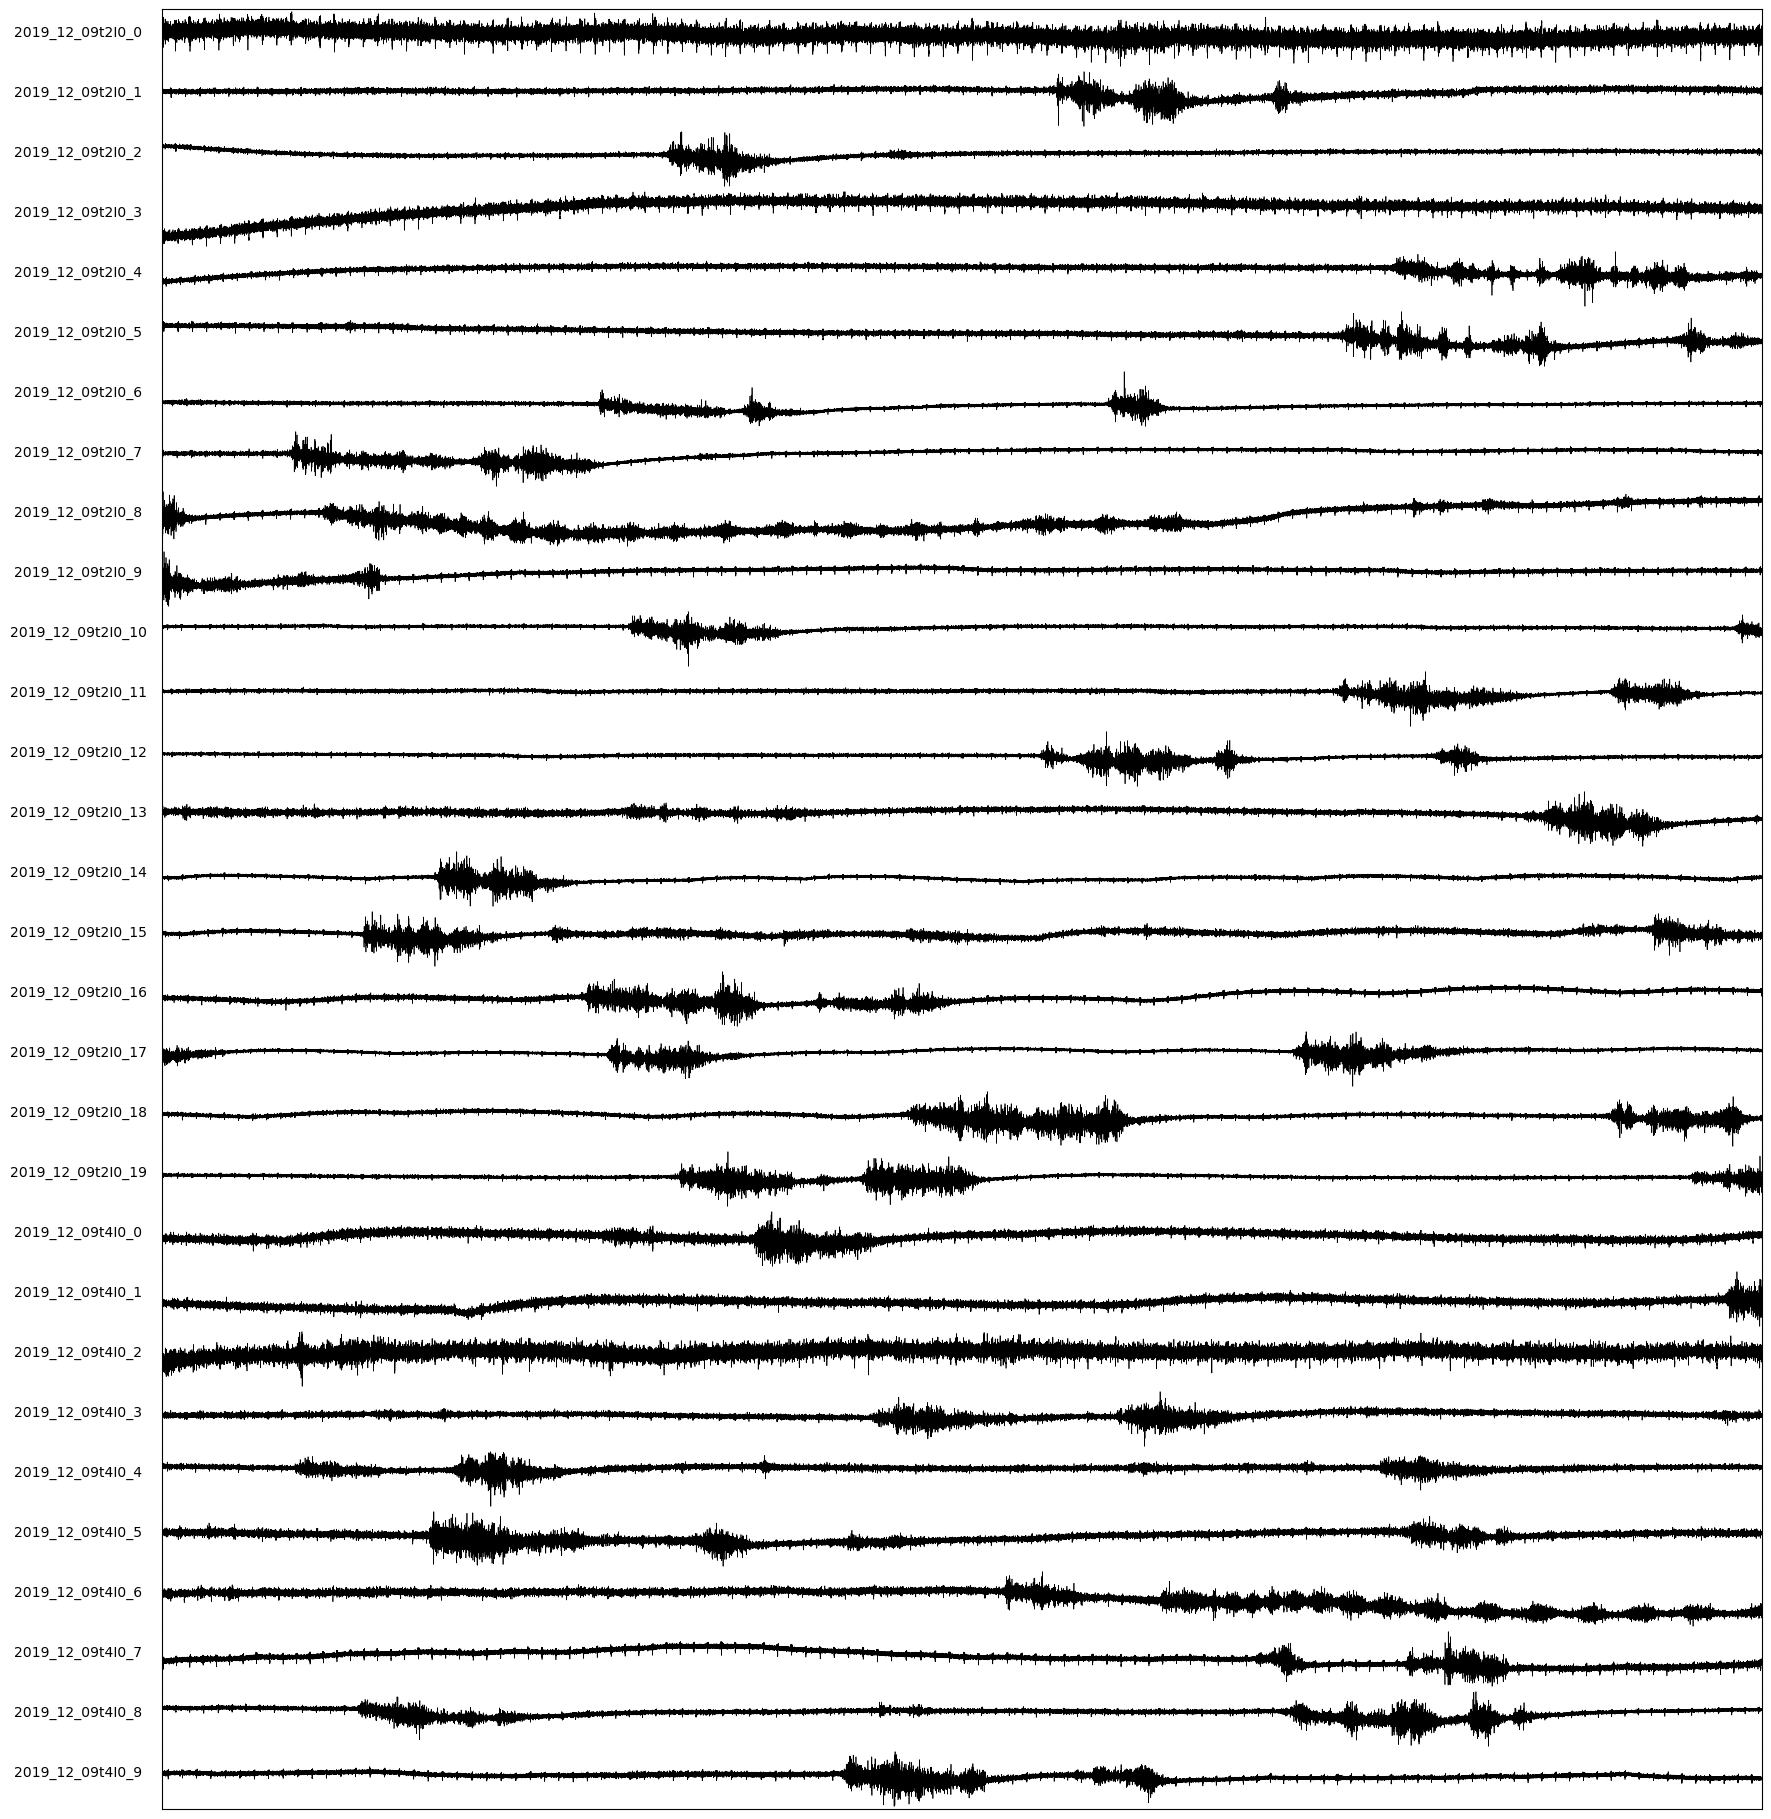

In [18]:
plot_channels(data = raw.get_data().T, time = raw.times, channels = channels, limit = None)

Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_87392/1935271028.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(picks = 'emg').plot(picks = 'emg')
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


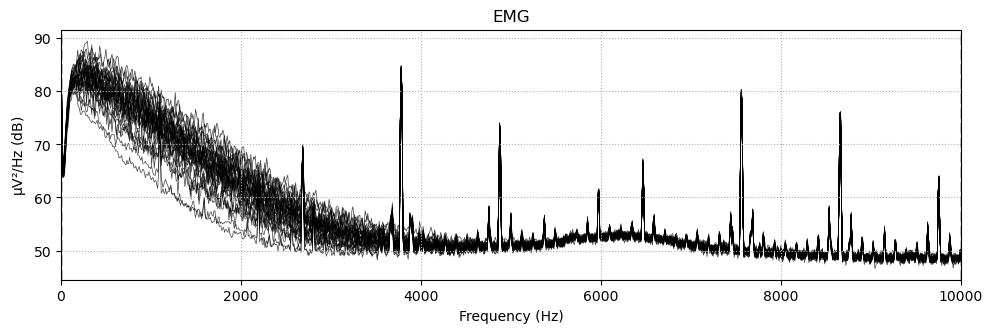

In [19]:
# Periodogram
raw.compute_psd(picks = 'emg').plot(picks = 'emg')
plt.show()

In [20]:
with open('output/spontaneous-movement/W1/C1/emg/filter.pkl', 'rb') as file:
    raw = pickle.load(file)

channels = raw.ch_names

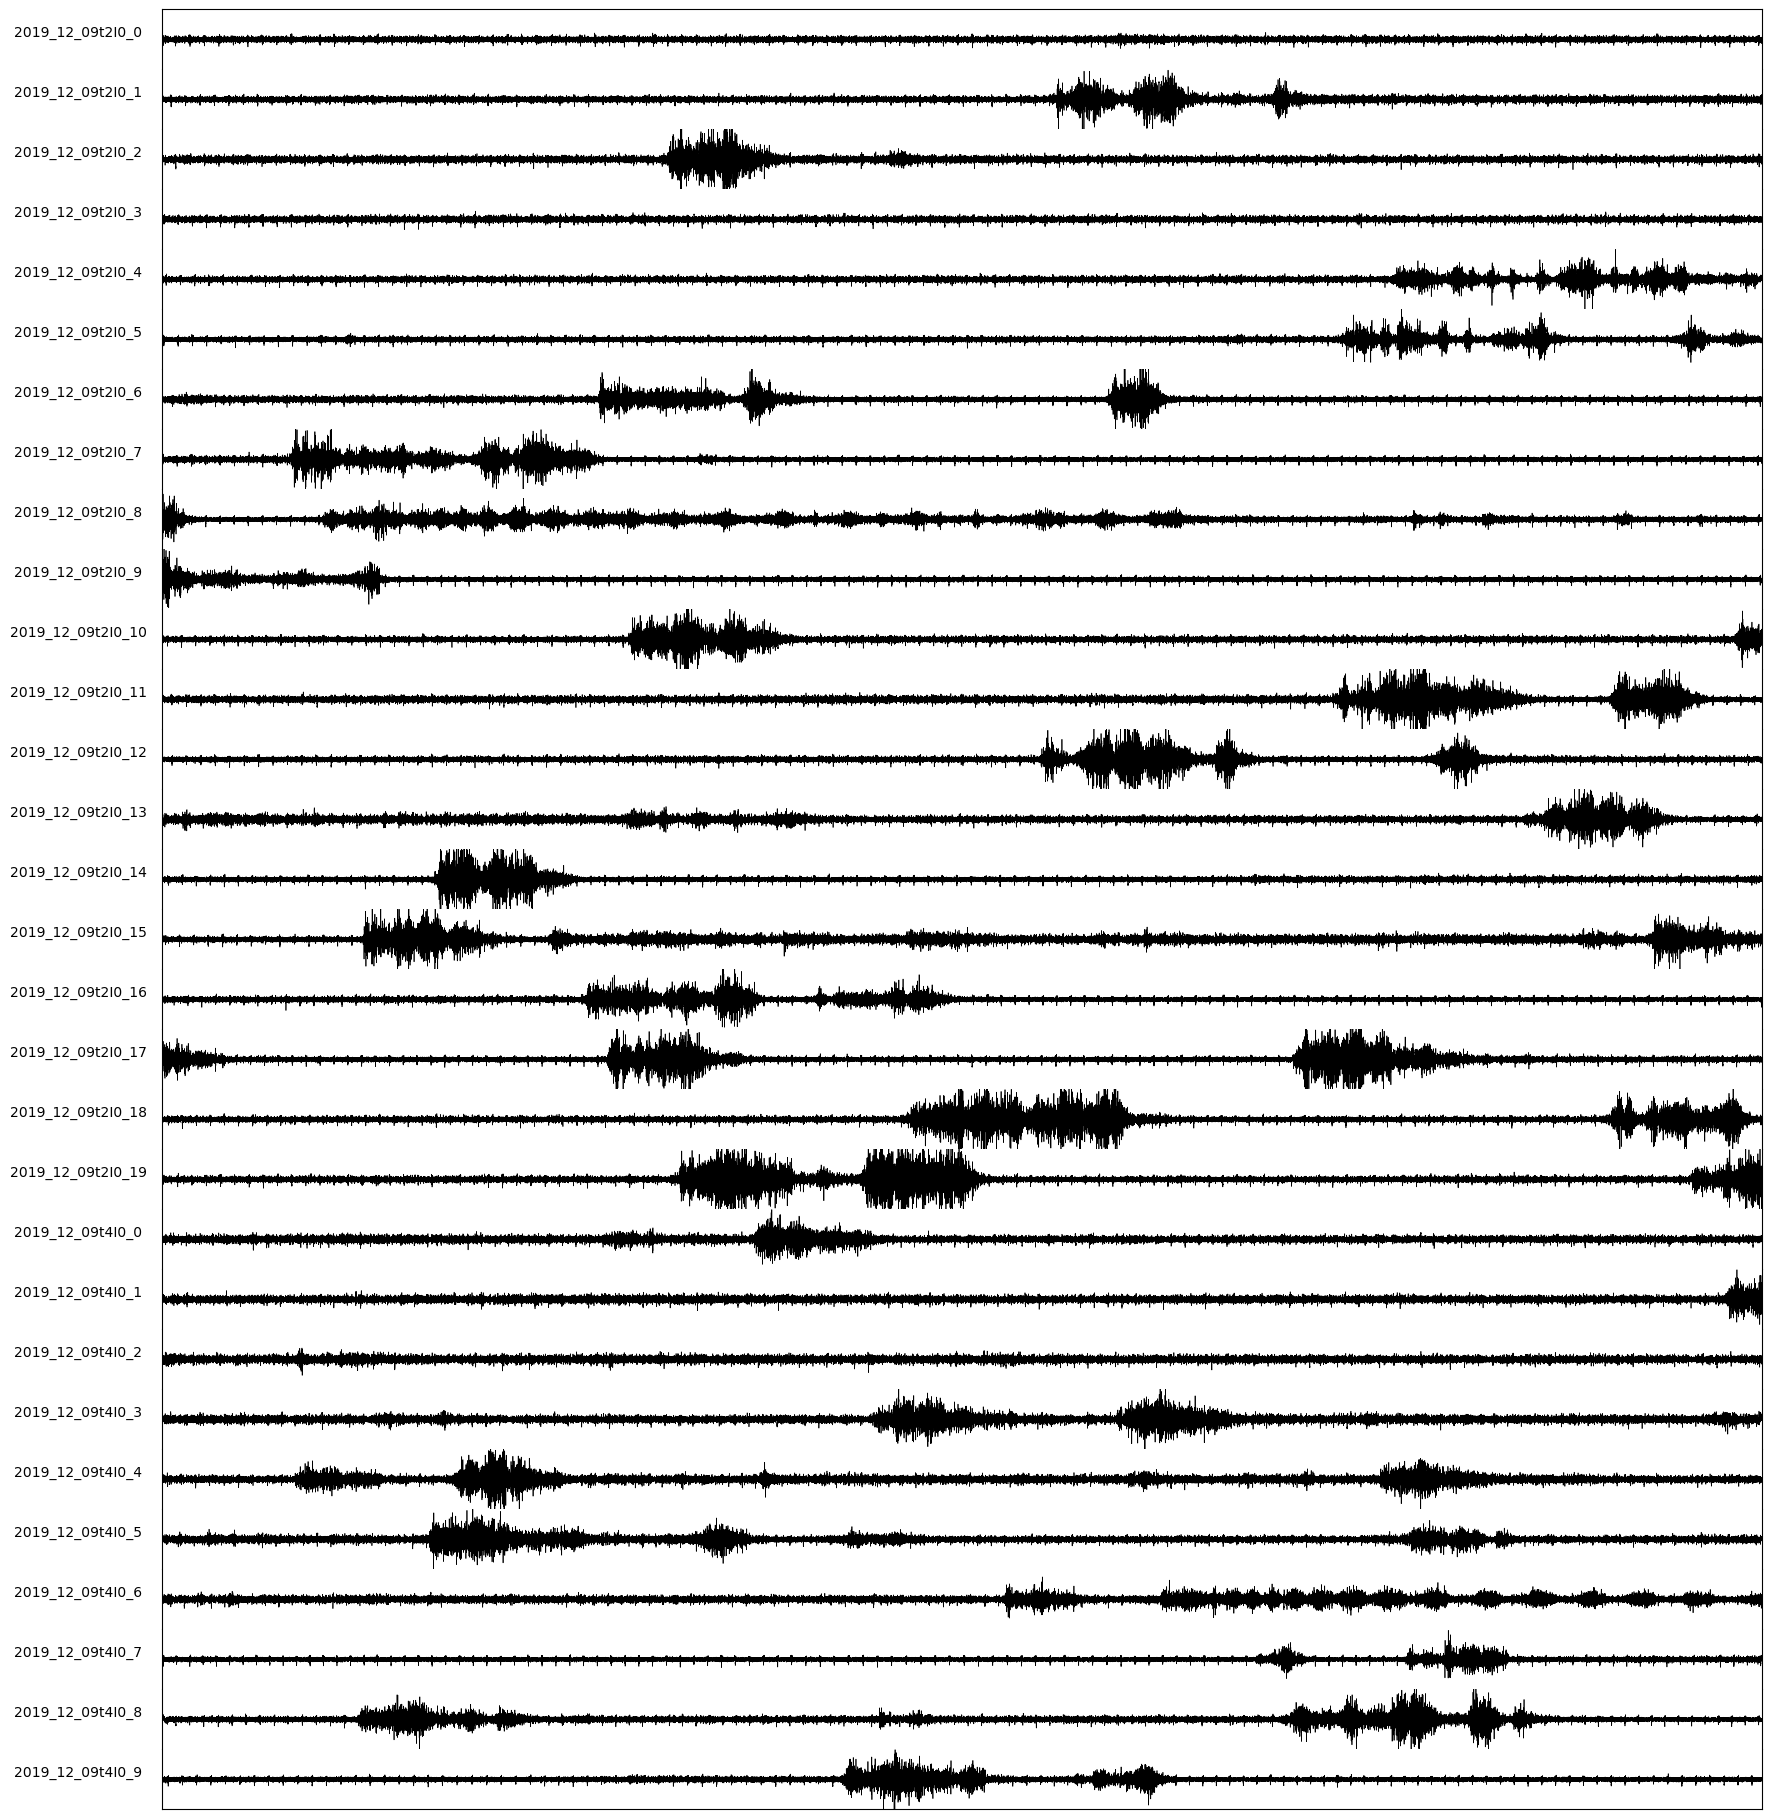

In [21]:
plot_channels(data = raw.get_data().T, time = raw.times, channels = channels, limit = 4)

Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_87392/3413662512.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(picks = channels[0]).plot(picks = channels[0])
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


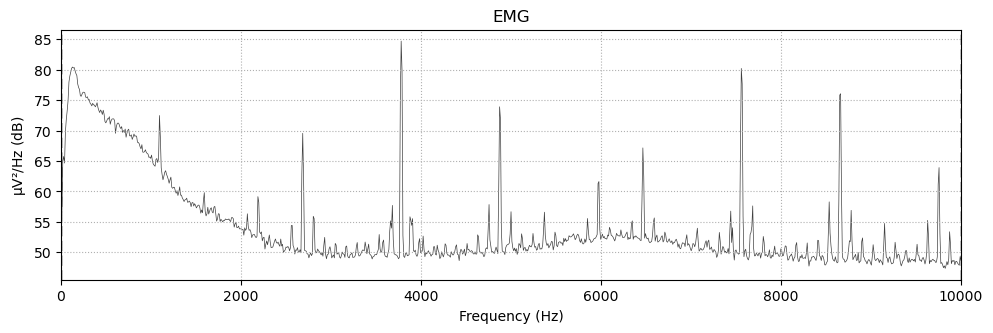

In [22]:
# Periodogram
raw.compute_psd(picks = channels[0]).plot(picks = channels[0])
plt.show()

In [23]:
# Tried ICA, but it did not manage to filter out the heartbeat.

# Questions:
# 1. Experimental design -- what exactly was done with these mice? Is EMG recorded from one cell as well? Do the EMG channels correspond somehow to Vm recordings?
# 2. Data filtering (low = 20 Hz, high = None)
# 3. What is considered movement? Is it those bursts of high amplitude signals? Do we consider it movement when there is "movement" in at least one channel?

## Teager-Kaiser Energy Operator

The Teager-Kaiser Energy Operator (TKEO) is used to improve the signal quality for onset movement detection. The formula for calculating the TKEO for any signal is as follows:

$$\Psi[x(n)] = x^2(n) - x(n + 1) \times x(n - 1)$$

In [24]:
def tkeo(signal):
    return signal[1:-1] ** 2 - signal[:-2] * signal[2:]

In [25]:
signal = raw.get_data(picks = [1])[0]

tke = tkeo(signal)
t = raw.times

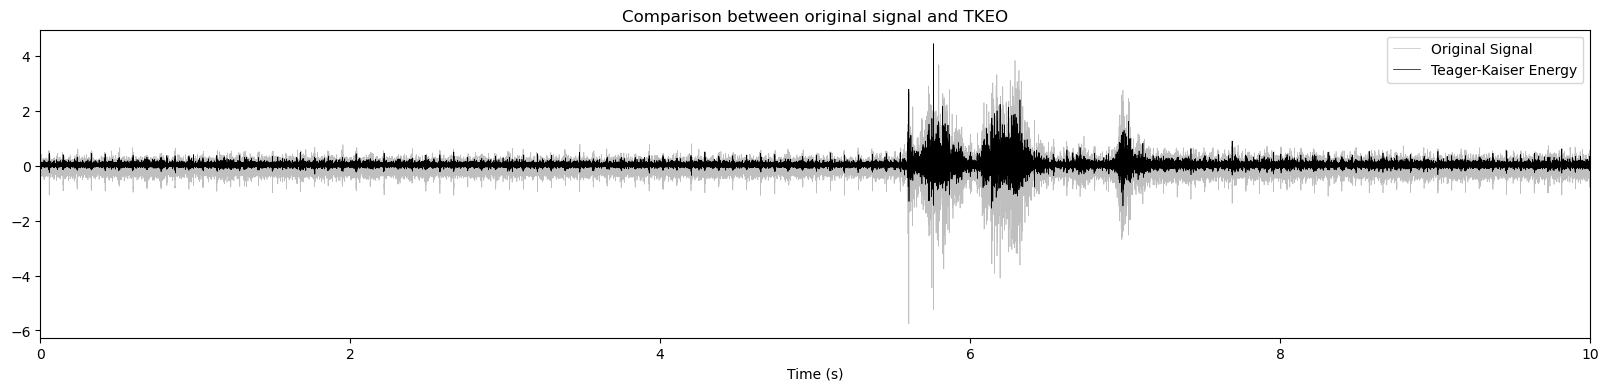

In [26]:
plt.figure(figsize = (20, 4))
plt.plot(t, signal, label = 'Original Signal', linewidth = 0.5, color = 'gray', alpha = 0.5)
plt.plot(t[1:-1], tke, label = 'Teager-Kaiser Energy', linewidth = 0.5, color = 'black')
plt.xlim(0, 10)
plt.xlabel('Time (s)')
plt.legend()
plt.title('Comparison between original signal and TKEO')
plt.show()

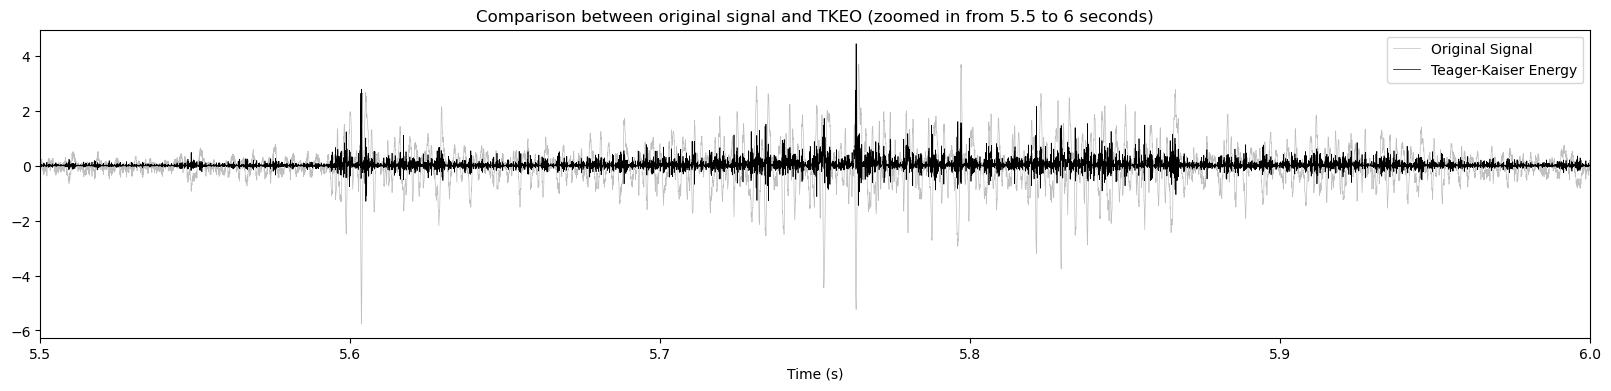

In [27]:
plt.figure(figsize = (20, 4))
plt.plot(t, signal, label = 'Original Signal', linewidth = 0.5, color = 'gray', alpha = 0.5)
plt.plot(t[1:-1], tke, label = 'Teager-Kaiser Energy', linewidth = 0.5, color = 'black')
plt.xlim(5.5, 6)
plt.xlabel('Time (s)')
plt.legend()
plt.title('Comparison between original signal and TKEO (zoomed in from 5.5 to 6 seconds)')
plt.show()

In [28]:
tke = []

for i, channel in enumerate(channels):
    signal = raw.get_data(picks = channel)[0]
    tke.append(tkeo(signal))

tke = np.array(tke).transpose()

ch_types = ['emg' for i in range(0, len(channels))]
info = mne.create_info(ch_names = channels, sfreq = sfreq, ch_types = ch_types)
tke = mne.io.RawArray(tke.T, info)

Creating RawArray with float64 data, n_channels=30, n_times=199999
    Range : 0 ... 199998 =      0.000 ...    10.000 secs
Ready.


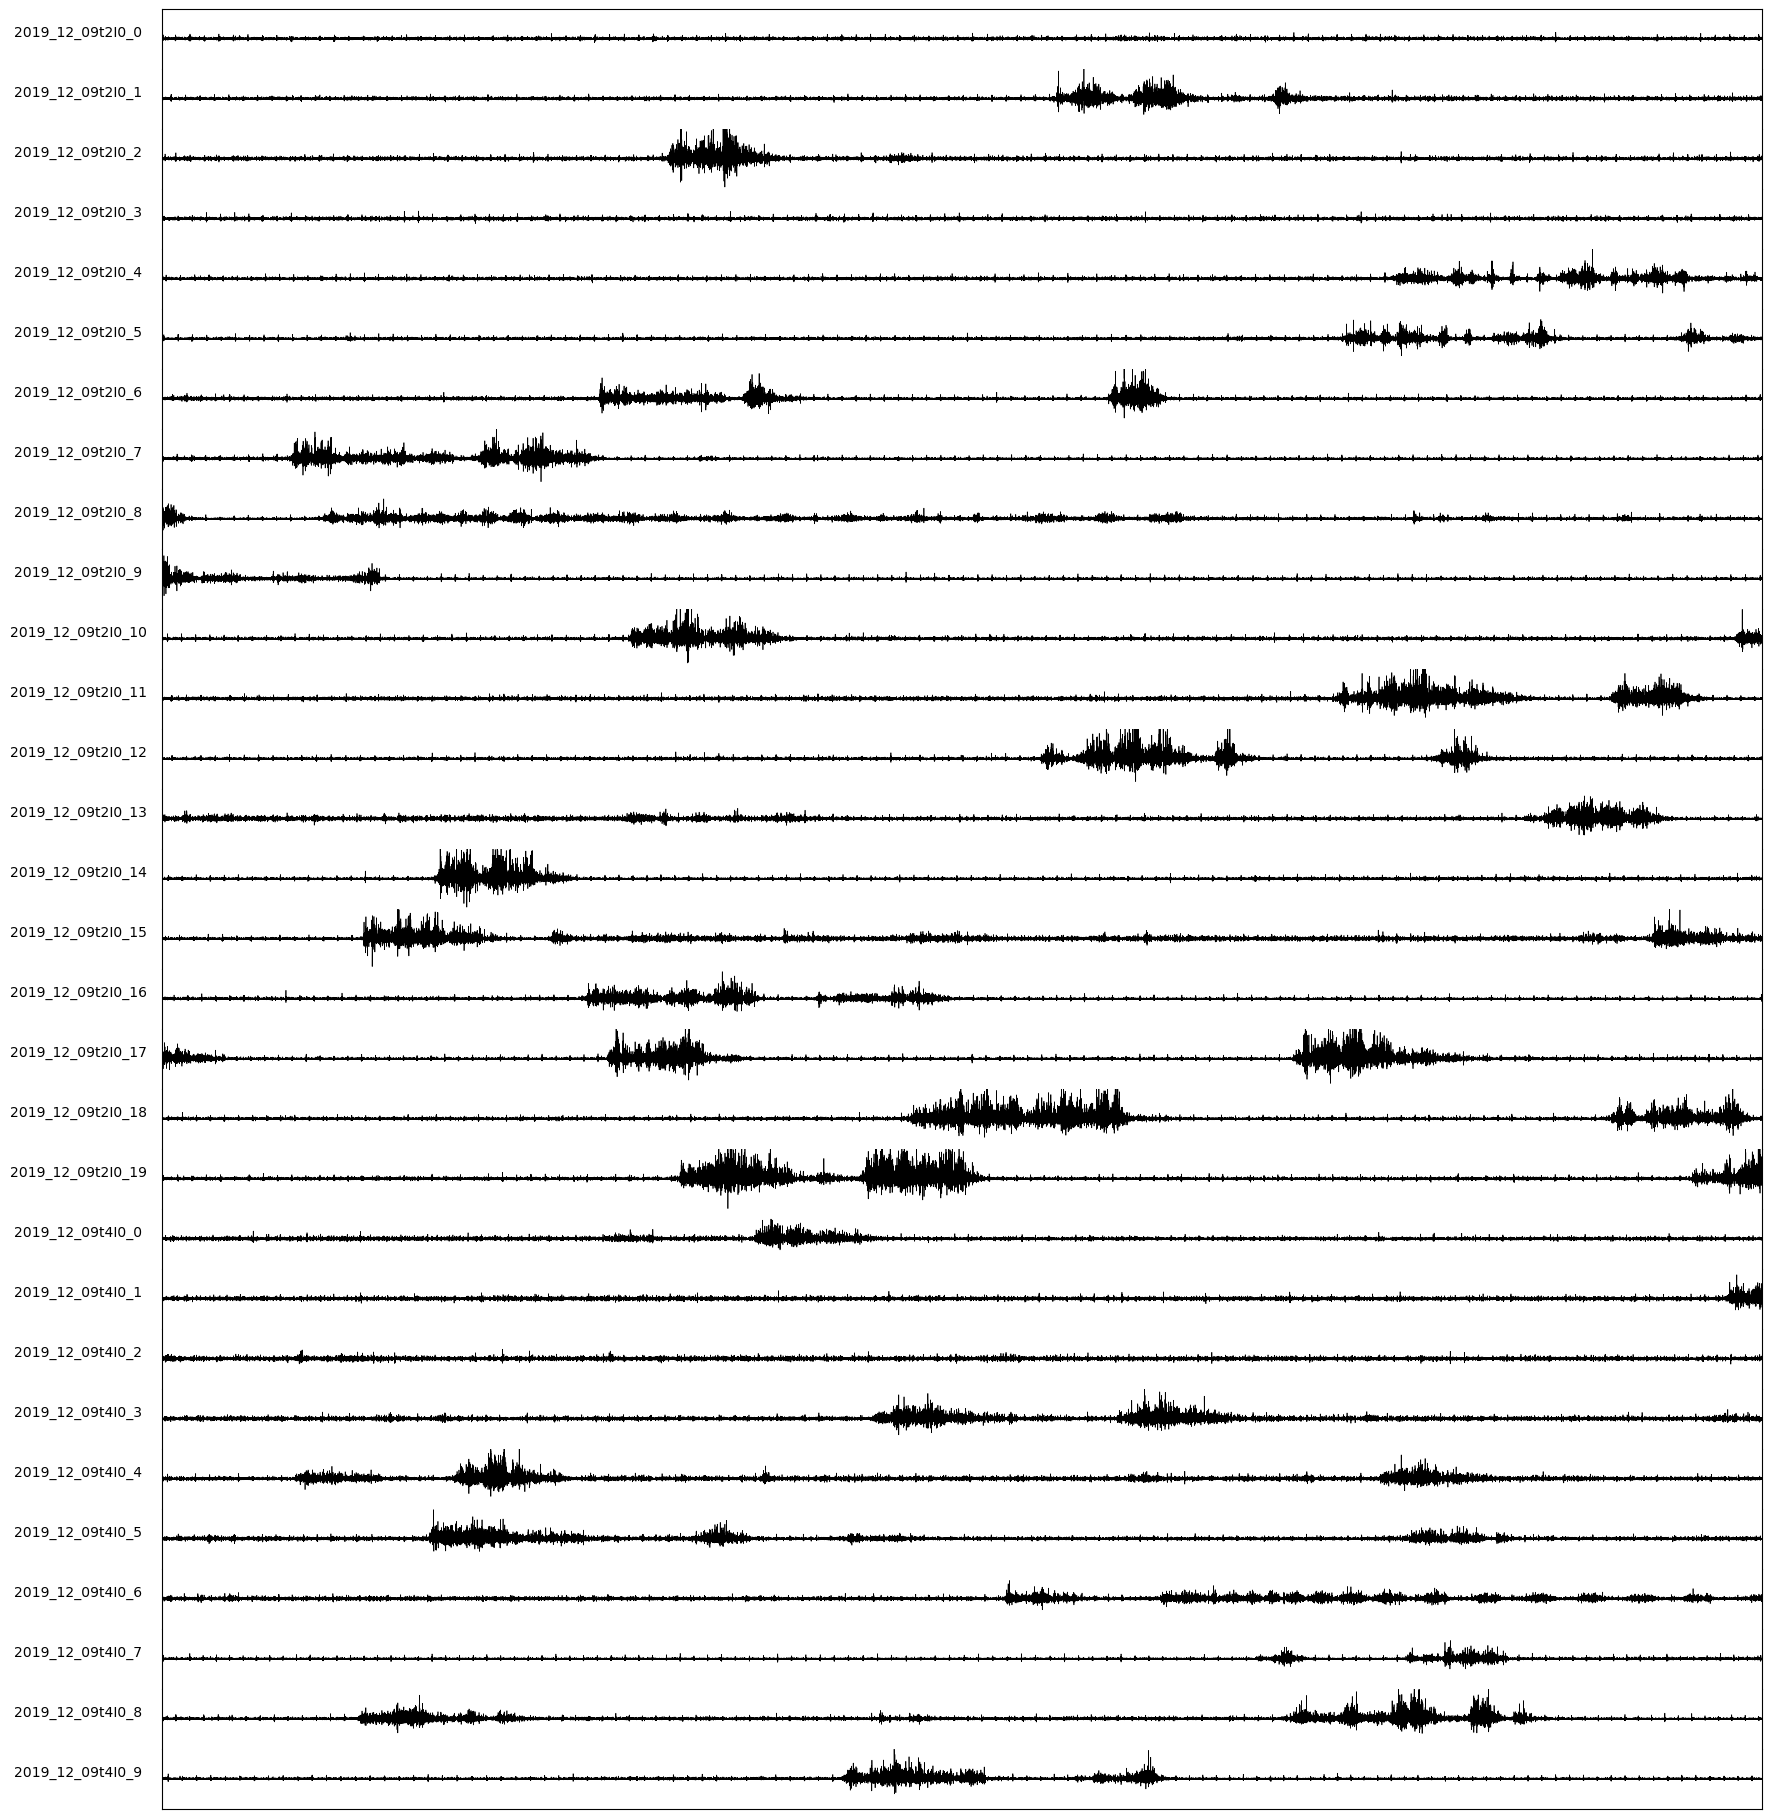

In [29]:
plot_channels(data = tke.get_data().T, time = tke.times, channels = channels, limit = 3)

Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_87392/525161481.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  tke.compute_psd(picks = 'emg').plot(picks = 'emg')
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


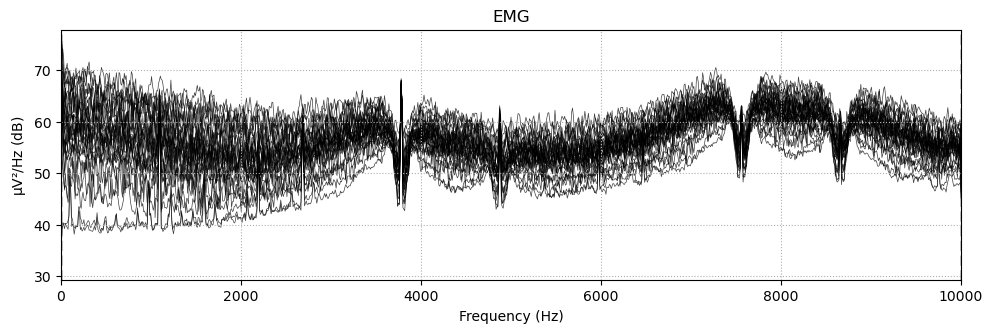

In [30]:
tke.compute_psd(picks = 'emg').plot(picks = 'emg')
plt.show()

In [31]:
tke.filter(l_freq = None, h_freq = 10, fir_design = 'firwin', picks = 'emg')

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 26401 samples (1.320 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


<RawArray | 30 x 199999 (10.0 s), ~45.8 MB, data loaded>

Effective window size : 0.102 (s)


/var/folders/qt/hgl1dlf168d7h94jf7mz7b3c0000gn/T/ipykernel_87392/525161481.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  tke.compute_psd(picks = 'emg').plot(picks = 'emg')
/Users/ieva/miniconda3/envs/mne/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


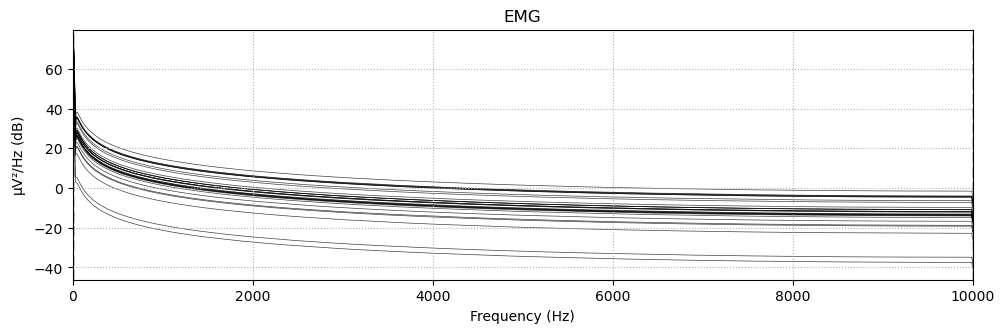

In [32]:
tke.compute_psd(picks = 'emg').plot(picks = 'emg')
plt.show()

In [33]:
def normalize(a, b, data):
    data_range = np.max(np.abs(data))
    return (b - a) * (data + data_range) / (2 * data_range) + a

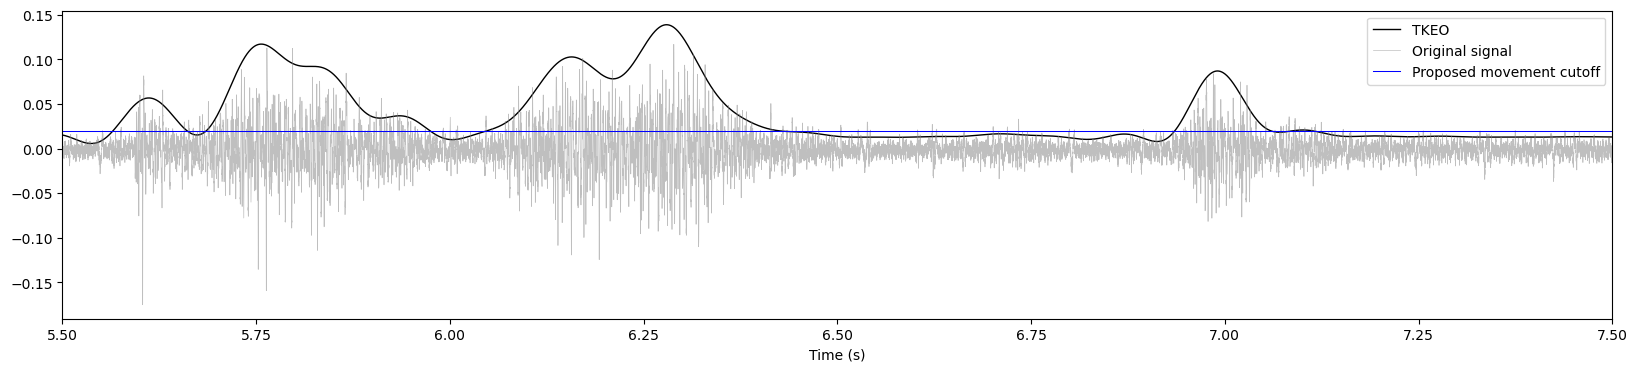

In [34]:
tke_signal = tke.get_data(picks = [1])[0]
tke_time = tke.times

signal = raw.get_data(picks = [1])[0]
normalized_signal = normalize(-0.175, 0.175, signal)
signal_time = raw.times

plt.figure(figsize = (20, 4))
plt.plot(tke_time, tke_signal, linewidth = 1, color = 'black', label = 'TKEO')
plt.plot(signal_time, normalized_signal, linewidth = 0.5, color = 'gray', alpha = 0.5, label = 'Original signal')
plt.xlabel('Time (s)')
plt.xlim(5.5, 7.5)
plt.axhline(y = 0.02, color = 'blue', linestyle = '-', linewidth = 0.75, label = 'Proposed movement cutoff')
plt.legend()
plt.show()

In [35]:
def merge_short(data, min_break = 200):
    i = 1
    while i < data.shape[0] - 1:
        if data.iloc[i]['Length'] >= min_break:
            i = i + 1
            continue

        previous_el = data.iloc[i - 1]
        next_el = data.iloc[i + 1]
        current = data.iloc[i]

        data.at[i, 'Length'] = previous_el['Length'] + next_el['Length'] + current['Length']
        data.at[i, 'EventStart'] = previous_el['EventStart']
        data.at[i, 'EventEnd'] = next_el['EventEnd']
        data.at[i, 'Movement'] = previous_el['Movement']

        data = data.drop(i - 1)
        data = data.drop(i + 1)
        data = data.reset_index(drop = True)

    return data


# TODO: expand start and end times
# TODO: afterwards, cut the expanded times for more precise movement detection
def extract_events(signal, sampling_rate, threshold = 0.02, min_event_length = 0.1, min_break = 200):
    min_points = sampling_rate * min_event_length  # The minimum number of consecutive points for movement detection

    signal_over_threshold = signal >= threshold
    change_indices = np.where(np.diff(signal_over_threshold))[0]

    movement_data = pd.DataFrame({
        'EventStart': change_indices[:-1],
        'EventEnd': change_indices[1:],
        'Movement': signal_over_threshold[change_indices[:-1] + 1]
    })

    movement_data['Length'] = movement_data.apply(lambda row: row.EventEnd - row.EventStart, axis = 1)
    movement_data = merge_short(movement_data, min_break = min_break)
    movement_data = movement_data[movement_data['Length'] >= min_points]
    movement_data = movement_data[movement_data['Movement'] == True]

    return movement_data

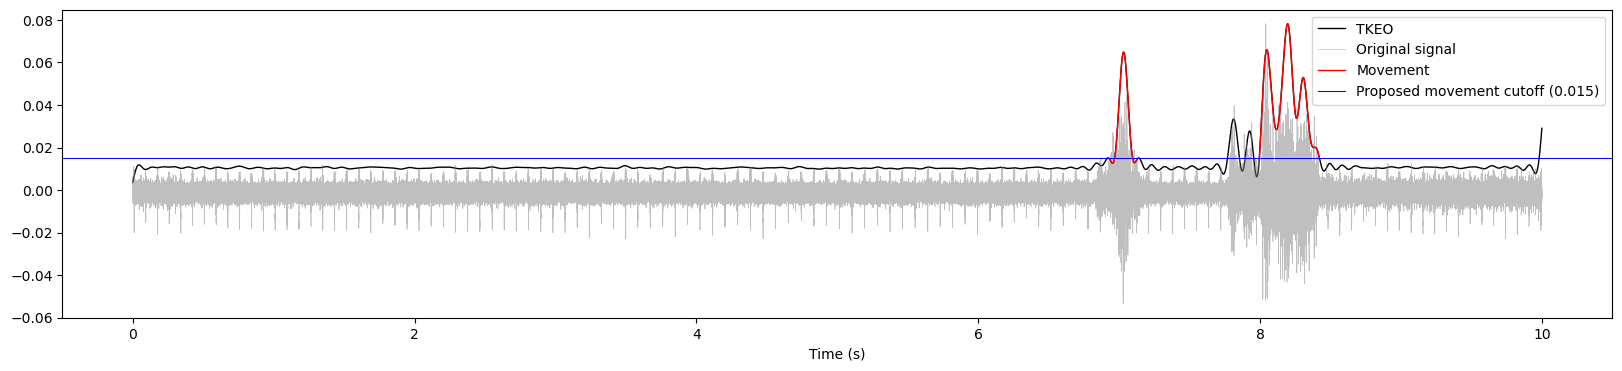

In [36]:
channel_i = -3

tke_signal = tke.get_data(picks = [channel_i])[0]
tke_time = tke.times

threshold = 0.015

move_events = extract_events(tke_signal, sampling_rate = sfreq, threshold = threshold, min_event_length = 0.1,
                             min_break = 2000)

signal = raw.get_data(picks = [channel_i])[0]

tke_range = np.max(np.abs(tke_signal))
normalized_signal = normalize(-tke_range, tke_range, signal)
signal_time = raw.times

plt.figure(figsize = (20, 4))
plt.plot(tke_time, tke_signal, linewidth = 1, color = 'black', label = 'TKEO')
plt.plot(signal_time, normalized_signal, linewidth = 0.5, color = 'gray', alpha = 0.5, label = 'Original signal')

has_label = False
for index, row in move_events.iterrows():
    start = row['EventStart']
    end = row['EventEnd']

    if has_label:
        plt.plot(tke_time[start:end], tke_signal[start:end], linewidth = 1, color = 'red')
    else:
        has_label = True
        plt.plot(tke_time[start:end], tke_signal[start:end], linewidth = 1, color = 'red', label = 'Movement')

# plt.xlim(5.5, 7.5)
plt.xlabel('Time (s)')
plt.axhline(y = threshold, color = 'blue', linestyle = '-', linewidth = 0.75,
            label = f'Proposed movement cutoff ({threshold})')
plt.legend()
plt.show()

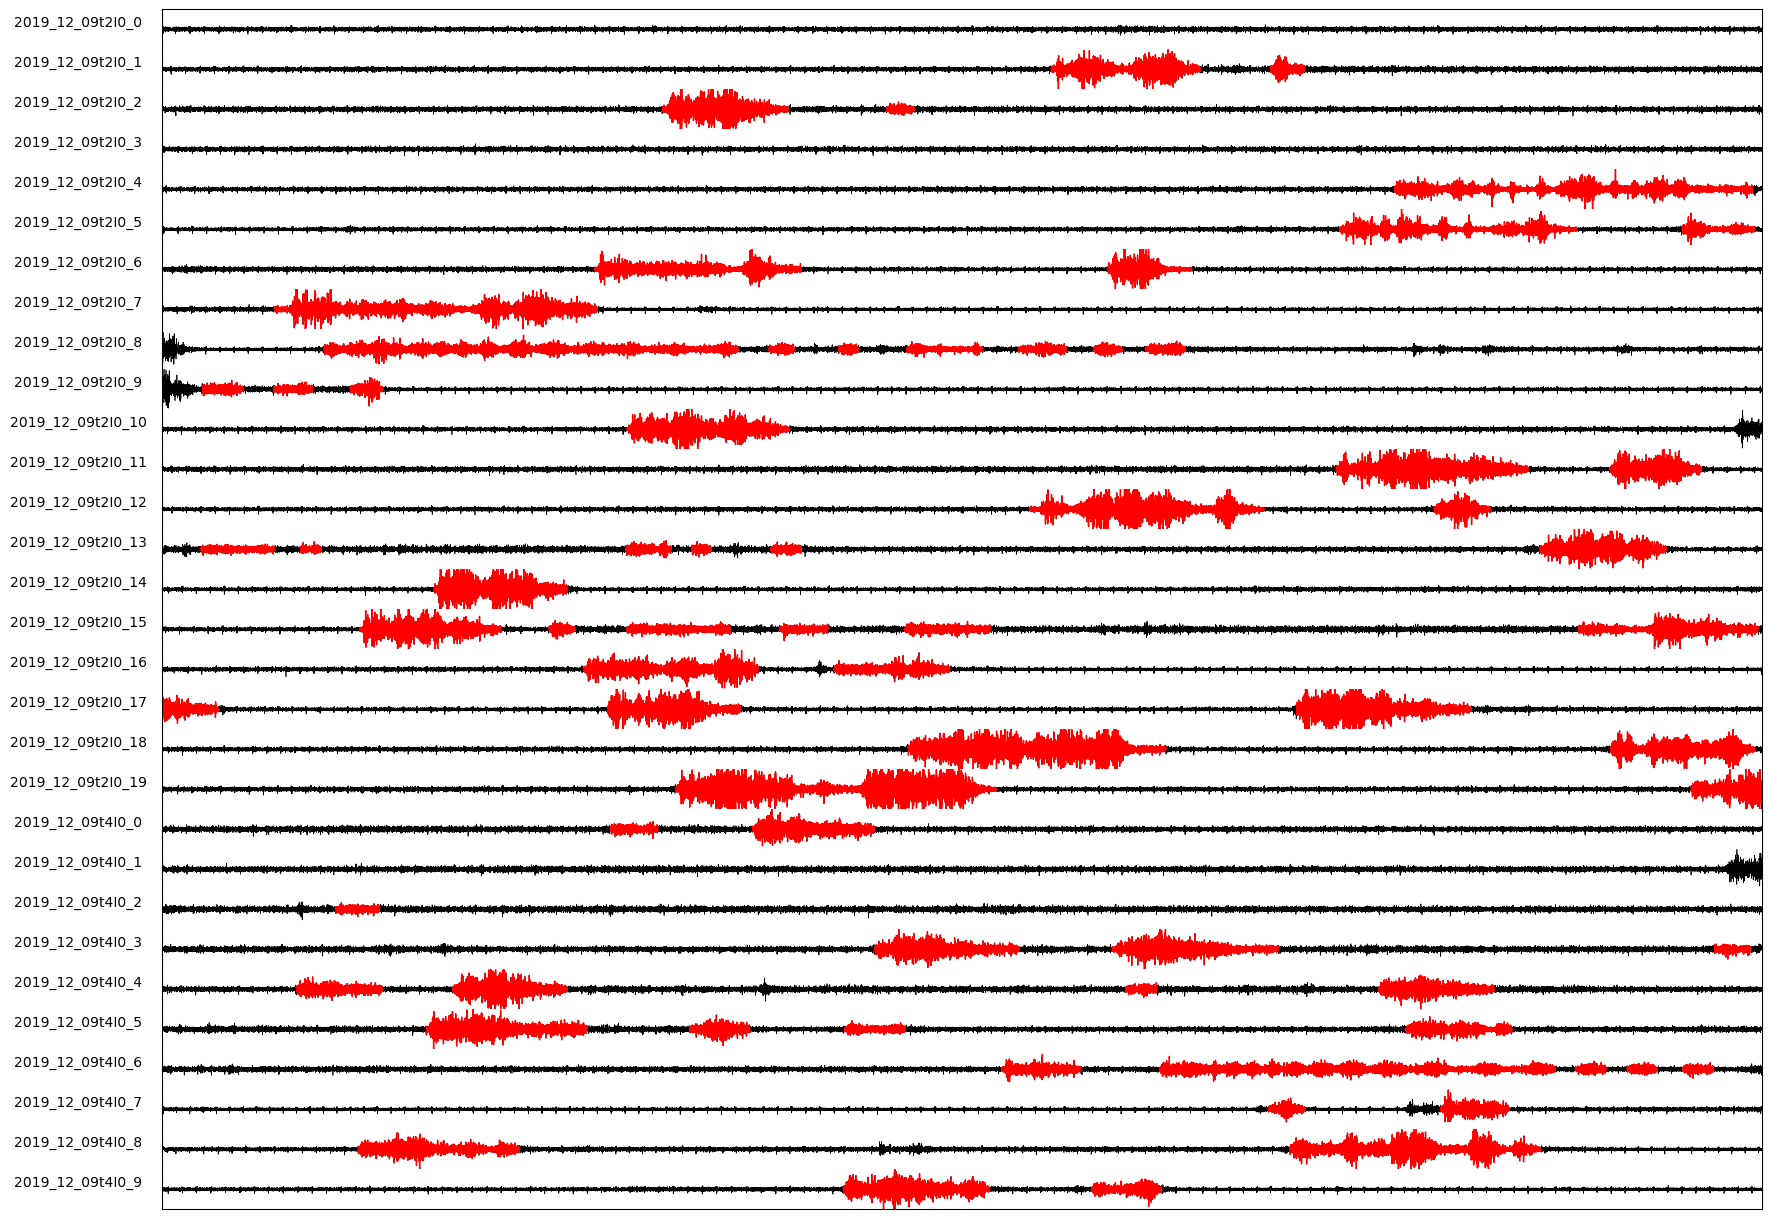

In [37]:
figure, axes = plt.subplots(nrows = len(channels), figsize = (20, 0.5 * len(channels)))
plt.subplots_adjust(
    left = 0.1,
    bottom = 0.1,
    right = 0.9,
    top = 0.9,
    wspace = 0,
    hspace = 0
)

x = raw.times

has_label = False

for i, channel in enumerate(channels):
    tke_signal = tke.get_data(picks = [i])[0]
    tke_time = tke.times

    move_events = extract_events(tke_signal, sampling_rate = sfreq, threshold = threshold, min_event_length = 0.1,
                                 min_break = 2000)

    y = raw.get_data(picks = [i])[0]

    axes[i].plot(x, y, linewidth = 0.5, color = 'black')
    axes[i].set_ylim(-4, 4)
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
    axes[i].set_ylabel(channel, rotation = 0, labelpad = 60, loc = 'center')
    axes[i].set_xlim(0, 10)

    for index, row in move_events.iterrows():
        start = row['EventStart']
        end = row['EventEnd']

        if has_label:
            axes[i].plot(x[start:end], y[start:end], linewidth = 1, color = 'red')
        else:
            has_label = True
            axes[i].plot(x[start:end], y[start:end], linewidth = 1, color = 'red', label = 'Movement')

    if i != 0:
        axes[i].spines['top'].set_visible(False)

    if i != len(channels) - 1:
        axes[i].spines['bottom'].set_visible(False)

plt.show()

In this step, the movement detection algorithm is more sensitive. The results will be filtered out later on to keep only good quality recordings.

Requirements for movement record:
- clear start phase (short time frame with no signal)
- clear (prolonged?) end phase
- strong average amplitude
- not too short, not too long

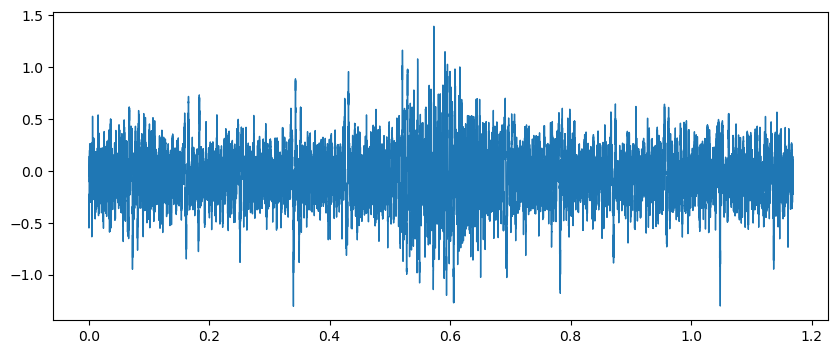

In [38]:
channel = 2
tke_signal = tke.get_data(picks = [channel])[0]
tke_time = tke.times

#
# Find movement events in this channel
#

move_events = extract_events(tke_signal, sampling_rate = sfreq, threshold = threshold, min_event_length = 0.1,
                             min_break = 2000)

#
# Extract a single movement data
#

start = move_events['EventStart'].iloc[1] / sfreq - 0.5
end = move_events['EventEnd'].iloc[1] / sfreq + 0.5

channel_data = raw.copy().pick(picks = [raw.ch_names[channel]]).crop(tmin = start, tmax = end)

plt.figure(figsize = (10, 4))
plt.plot(channel_data.times, channel_data.get_data()[0], linewidth = 1)
plt.show()

In [39]:
event_id = 1

# Which time period before / after signal should be considered
calm_time = 0.25
# (Detection filter) Minimum movement signal amplitude
min_movement_amplitude = 0.5
# (Quality filter) Minimum difference between the amplitudes of calm vs movement
min_amplitude_difference = 0.5

In [40]:
start = move_events['EventStart'].iloc[event_id] / sfreq
end = move_events['EventEnd'].iloc[event_id] / sfreq
channel_data = raw.copy().pick(picks = [raw.ch_names[channel]]).crop(tmin = start, tmax = end)
np.sqrt(np.mean(np.square(channel_data.get_data()[0])))

0.38209330231150107

In [41]:
start = move_events['EventStart'].iloc[event_id] / sfreq - calm_time
end = move_events['EventStart'].iloc[event_id] / sfreq
channel_data = raw.copy().pick(picks = [raw.ch_names[channel]]).crop(tmin = start, tmax = end)
np.sqrt(np.mean(np.square(channel_data.get_data()[0])))

0.22898974808547387

In [42]:
start = move_events['EventEnd'].iloc[event_id] / sfreq
end = move_events['EventEnd'].iloc[event_id] / sfreq + calm_time
channel_data = raw.copy().pick(picks = [raw.ch_names[channel]]).crop(tmin = start, tmax = end)
np.sqrt(np.mean(np.square(channel_data.get_data()[0])))

0.23592075472203083

In [893]:
# TODO: align all signals on each other
# TODO: prepare vm signal
# TODO: correlation with vm
# TODO: average vm amplitude in signal vs no signal
# TODO: extract periods with no signal (good quality)